In [2]:
!pip install nixtlats

In [3]:
!pip install mlforecast
!pip install matplotlib

In [4]:

import pandas as pd
from nixtlats import TimeGPT  # Importing the TimeGPT class from nixtlats library.
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import csv
#import pdcast as pdc


import re
import os
import time

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier


# Initializing the `TimeGPT` class with a token from the environment variable.
timegpt = TimeGPT(token='s8ghA5oSQ8PnHcRZyEsxN6CCzitO8Vtsx0A98cyrqrtMg5CbwffTnV3qvIzDBXQRlSguspPtY09S3uvr3hnBy67AwkdWak6W4pcCKAeqwOUXeFOcaNz0bfUWM9F7NeU9vbKuCdk867DN5pELECl4oKrvQ5aOGdfTIeALcmk4JY0MWj3BaMVN8dO7Q83c7llcL7SFWtnn2FI97vJY7ZxVCNMOkHutxIzGhT35aL540aRjdOiysnzFh8ThY7LLFKEa') #https://dashboard.nixtla.io


In [5]:
from google.colab import drive
drive.mount('/content/drive')

PATH = '/content/drive/MyDrive/data_science/5.Walmart Recruiting - Store Sales Forecasting/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# data
df_train = pd.read_csv(PATH + "train.csv" , index_col= False)
df_test = pd.read_csv(PATH + "test.csv" , index_col= False)
df_features = pd.read_csv(PATH + "features.csv" , index_col= False)
df_stores = pd.read_csv(PATH + "stores.csv" , index_col= False)

In [7]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [8]:
df_test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [9]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [10]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [11]:
# 3. Time series
# Convert the 'date' column to DateTime objects
df_train['Date'] = pd.to_datetime(df_train['Date'] , dayfirst=True)
df_test['Date'] = pd.to_datetime(df_test['Date'] , dayfirst=True)
df_features['Date'] = pd.to_datetime(df_features['Date'] , dayfirst=True)


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Store      115064 non-null  int64         
 1   Dept       115064 non-null  int64         
 2   Date       115064 non-null  datetime64[ns]
 3   IsHoliday  115064 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2)
memory usage: 2.7 MB


# Data preprocessing

In [13]:
# We add a new column, that indicates the week number
df_train['Week'] = df_train['Date'].dt.week
df_test['Week'] = df_test['Date'].dt.week

<ipython-input-13-a3f2e190e672>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_train['Week'] = df_train['Date'].dt.week
<ipython-input-13-a3f2e190e672>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_test['Week'] = df_test['Date'].dt.week


In [14]:
# New column for the day of the week
df_train['Day_of_week'] =df_train['Date'].dt.dayofweek
df_test['Day_of_week'] =df_test['Date'].dt.dayofweek

In [15]:
df_train['Month'] =df_train['Date'].dt.month
df_test['Month'] = df_test['Date'].dt.month
df_train['Year'] =df_train['Date'].dt.year
df_test['Year'] =df_test['Date'].dt.year
df_train['Day_of_Month'] =df_train['Date'].dt.day
df_test['Day_of_Month'] =df_test['Date'].dt.day

In [16]:
# Merge all features with train and test
# the more columns we have the better will be the prediction
# train has weekly sales
train_with_feature = pd.merge_asof(df_train, df_features, on='Store',by='Date')
test_with_feature = pd.merge_asof(df_test, df_features, on='Store',by='Date')


In [17]:
df_features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [18]:
# Merge train and test with df stores
train_with_feature_new = pd.merge(train_with_feature,df_stores)
test_with_feature_new = pd.merge(test_with_feature,df_stores)

In [19]:
# We remove Is_Holiday duplicated column and rename it
train_with_feature = train_with_feature_new.drop(columns=['IsHoliday_x'])
test_with_feature = test_with_feature_new.drop(columns=['IsHoliday_x'])

# Let's rename the IsHoliday_y column to IsHoliday
train_with_feature = train_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})
test_with_feature = test_with_feature.rename(columns={"IsHoliday_y": "IsHoliday"})

In [20]:
# Is_Holiday convert True = 1, and False = 0
def paron(x):
    if x == False:
        return 0
    return 1

# Train.csv
actual_score = train_with_feature['IsHoliday']
# Apply the function to the dataset
posiveNegave = actual_score.map(paron)
train_with_feature['IsHoliday'] = posiveNegave

print("Shape of train_with_feature: ", train_with_feature.shape)
train_with_feature.head(3)

Shape of train_with_feature:  (421570, 21)


,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,A,151315
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,A,151315
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,A,151315


In [21]:
# Is_Holiday convert True = 1, and False = 0
# convert the the False to 0
def paron(x):
    if x == False:
        return 0
    return 1

# Test.csv
actual_score2 = test_with_feature['IsHoliday']
# Apply the function to the dataset
posiveNegave2 = actual_score2.map(paron)
test_with_feature['IsHoliday'] = posiveNegave2

print("Shape of test_with_feature: ", test_with_feature.shape)
test_with_feature.head(3)

Shape of test_with_feature:  (115064, 20)


,Store,Dept,Date,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2012-11-02,44,4,11,2012,2,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,0,A,151315
1,1,1,2012-11-09,45,4,11,2012,9,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,0,A,151315
2,1,1,2012-11-16,46,4,11,2012,16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,0,A,151315


In [22]:
# Convert the categorical features into numerical features
def type_count(x):
    ''' This function will change
    the store type column with Flase to be 0
    and True to be 1'''

    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    return 3

#Train.csv
actualScore = train_with_feature['Type']
type_coun = actualScore.map(type_count)
train_with_feature['Types'] = type_coun

In [23]:
train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Types
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,...,NaN,NaN,NaN,NaN,211.096358,8.106,0,A,151315,1
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,...,NaN,NaN,NaN,NaN,211.242170,8.106,1,A,151315,1
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,...,NaN,NaN,NaN,NaN,211.289143,8.106,0,A,151315,1
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,...,NaN,NaN,NaN,NaN,211.319643,8.106,0,A,151315,1
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,...,NaN,NaN,NaN,NaN,211.350143,8.106,0,A,151315,1


In [24]:
# Convert the categorical features into numerical features
def type_count(x):
    ''' This function will change
    the store type column with Flase to be 0
    and True to be 1'''

    if x == 'A':
        return 1
    elif x == 'B':
        return 2
    return 3

#Test.csv
actualScore = test_with_feature['Type']
type_coun = actualScore.map(type_count)
test_with_feature['Types'] = type_coun

In [25]:
test_with_feature.head()

,Store,Dept,Date,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Types
0,1,1,2012-11-02,44,4,11,2012,2,55.32,3.386,...,5147.70,50.82,3639.90,2737.42,223.462779,6.573,0,A,151315,1
1,1,1,2012-11-09,45,4,11,2012,9,61.24,3.314,...,3370.89,40.28,4646.79,6154.16,223.481307,6.573,0,A,151315,1
2,1,1,2012-11-16,46,4,11,2012,16,52.92,3.252,...,292.10,103.78,1133.15,6612.69,223.512911,6.573,0,A,151315,1
3,1,1,2012-11-23,47,4,11,2012,23,56.23,3.211,...,4.17,74910.32,209.91,303.32,223.561947,6.573,1,A,151315,1
4,1,1,2012-11-30,48,4,11,2012,30,52.34,3.207,...,NaN,3838.35,150.57,6966.34,223.610984,6.573,0,A,151315,1


In [26]:
# remove the Type categorcial column
train_with_feature=train_with_feature.drop(['Type'], axis=1)
test_with_feature=test_with_feature.drop(['Type'], axis=1)

In [27]:
train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Size,Types
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,...,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,151315,1
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,...,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,151315,1
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,...,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,151315,1
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,...,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,151315,1
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,...,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,151315,1


In [28]:
# Let's take mean of Temperature and Unemployment
# train
train_with_feature['Temperature_mean'] = train_with_feature['Temperature'].mean()
train_with_feature['Unemployment_mean'] = train_with_feature['Unemployment'].mean()

# test
test_with_feature['Temperature_mean'] = test_with_feature['Temperature'].mean()
test_with_feature['Unemployment_mean'] = test_with_feature['Unemployment'].mean()

In [29]:
train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,...,NaN,NaN,NaN,211.096358,8.106,0,151315,1,60.090059,7.960289
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,...,NaN,NaN,NaN,211.242170,8.106,1,151315,1,60.090059,7.960289
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,...,NaN,NaN,NaN,211.289143,8.106,0,151315,1,60.090059,7.960289
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,...,NaN,NaN,NaN,211.319643,8.106,0,151315,1,60.090059,7.960289
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,...,NaN,NaN,NaN,211.350143,8.106,0,151315,1,60.090059,7.960289


In [30]:
train_with_feature.isnull().sum()

Store                     0
Dept                      0
Date                      0
Weekly_Sales              0
Week                      0
Day_of_week               0
Month                     0
Year                      0
Day_of_Month              0
Temperature               0
Fuel_Price                0
MarkDown1            270889
MarkDown2            310322
MarkDown3            284479
MarkDown4            286603
MarkDown5            270138
CPI                       0
Unemployment              0
IsHoliday                 0
Size                      0
Types                     0
Temperature_mean          0
Unemployment_mean         0
dtype: int64

In [31]:
test_with_feature.isnull().sum()

Store                    0
Dept                     0
Date                     0
Week                     0
Day_of_week              0
Month                    0
Year                     0
Day_of_Month             0
Temperature              0
Fuel_Price               0
MarkDown1              149
MarkDown2            28627
MarkDown3             9829
MarkDown4            12888
MarkDown5                0
CPI                  38162
Unemployment         38162
IsHoliday                0
Size                     0
Types                    0
Temperature_mean         0
Unemployment_mean        0
dtype: int64

In [32]:
# Bi variate analisis
correlation = train_with_feature[['Weekly_Sales', 'Store' , 'Dept' , 'Week' , 'Day_of_week' , 'Month' , 'Year' , 'Temperature_mean' , 'Unemployment_mean' , 'IsHoliday' , 'Types']].corr()
correlation


,Weekly_Sales,Store,Dept,Week,Day_of_week,Month,Year,Temperature_mean,Unemployment_mean,IsHoliday,Types
Weekly_Sales,1.000000,-0.085195,0.148032,0.027673,NaN,0.028409,-0.010111,NaN,NaN,0.012774,-0.182242
Store,-0.085195,1.000000,0.024004,0.001031,NaN,0.001011,0.002997,NaN,NaN,-0.000548,0.226410
Dept,0.148032,0.024004,1.000000,0.000882,NaN,0.000904,0.003738,NaN,NaN,0.000916,0.003708
Week,0.027673,0.001031,0.000882,1.000000,NaN,0.995999,-0.181797,NaN,NaN,0.128184,-0.000003
Day_of_week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,0.028409,0.001011,0.000904,0.995999,NaN,1.000000,-0.194288,NaN,NaN,0.123376,-0.000069
Year,-0.010111,0.002997,0.003738,-0.181797,NaN,-0.194288,1.000000,NaN,NaN,-0.056746,0.004208
Temperature_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unemployment_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsHoliday,0.012774,-0.000548,0.000916,0.128184,NaN,0.123376,-0.056746,NaN,NaN,1.000000,-0.000798


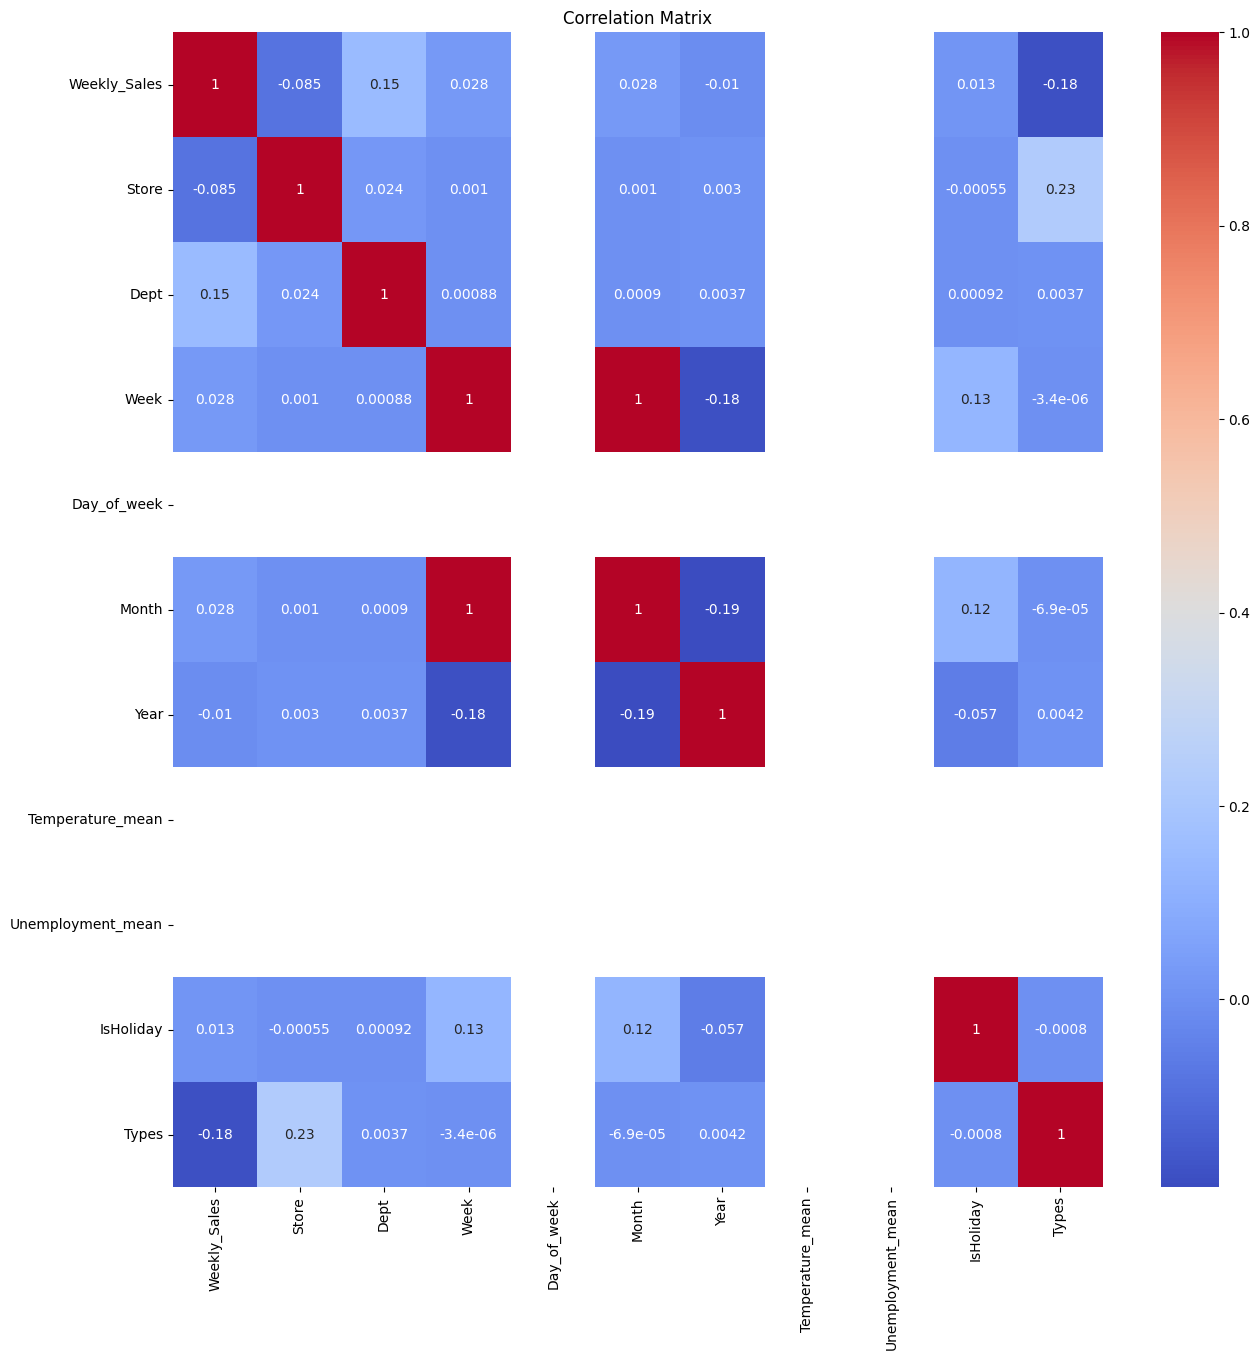

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation , annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [34]:
# Let's drop the Markdown, CPI and Unemployment columns because there are many null values
columns_to_drop = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4' , 'MarkDown5' , 'CPI', 'Unemployment']

# Drop the specified columns
train_with_feature = train_with_feature.drop(columns=columns_to_drop)
test_with_feature = test_with_feature.drop(columns=columns_to_drop)

In [35]:
train_with_feature.head()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,2.572,0,151315,1,60.090059,7.960289
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,2.548,1,151315,1,60.090059,7.960289
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,2.514,0,151315,1,60.090059,7.960289
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,2.561,0,151315,1,60.090059,7.960289
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,2.625,0,151315,1,60.090059,7.960289


In [36]:
train_with_feature.tail()

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
421565,45,98,2012-09-28,508.37,39,4,9,2012,28,64.88,3.997,0,118221,2,60.090059,7.960289
421566,45,98,2012-10-05,628.10,40,4,10,2012,5,64.89,3.985,0,118221,2,60.090059,7.960289
421567,45,98,2012-10-12,1061.02,41,4,10,2012,12,54.47,4.000,0,118221,2,60.090059,7.960289
421568,45,98,2012-10-19,760.01,42,4,10,2012,19,56.47,3.969,0,118221,2,60.090059,7.960289
421569,45,98,2012-10-26,1076.80,43,4,10,2012,26,58.85,3.882,0,118221,2,60.090059,7.960289


# Final test and train data

In [37]:
# Split the train and test features
train_final = train_with_feature
test_final = test_with_feature

In [38]:
# Let's do a copy of the datasets
train_timegpt = train_final.copy()
test_timegpt = test_final.copy()

In [39]:
# train X=  All except Weekly_Sales and Date
train_X=train_final.drop(['Weekly_Sales','Date'], axis=1)

# train Y= Only Weekly_Sales
train_y=train_final['Weekly_Sales']

# we drop date we take all the features, will predict on weekly sales
test_X=test_final.drop('Date',axis=1).copy()

# predict test_y

In [40]:
# check the shape
train_X.shape, train_y.shape, test_X.shape

((421570, 14), (421570,), (115064, 14))

In [41]:
train_X.isna().sum()

Store                0
Dept                 0
Week                 0
Day_of_week          0
Month                0
Year                 0
Day_of_Month         0
Temperature          0
Fuel_Price           0
IsHoliday            0
Size                 0
Types                0
Temperature_mean     0
Unemployment_mean    0
dtype: int64

In [42]:
test_X.isna().sum()

Store                0
Dept                 0
Week                 0
Day_of_week          0
Month                0
Year                 0
Day_of_Month         0
Temperature          0
Fuel_Price           0
IsHoliday            0
Size                 0
Types                0
Temperature_mean     0
Unemployment_mean    0
dtype: int64

In [43]:
train_y.isna().sum()

0

# ML Model Random Forest Regressor

In [44]:
# We have lots of decision trees running together, it runs one by one.
# Tunning the parameters to increase the accuracy.

clf = RandomForestRegressor(n_estimators=50)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100,3)
print (f"Accuracy: {acc_rf} %")


Accuracy: 99.716 %


In [45]:
# predicted values
print(y_pred_rf)

[35858.9434 20964.8488 18980.6346 ...   792.6174   758.2808   694.1356]


In [46]:
# Check the values for the prediction
# Converts the y_pred_rf into csv file
submission = pd.DataFrame({
         "Id": df_test.Store.astype(str)+'_'+df_test.Dept.astype(str)+'_'+df_test.Date.astype(str),
         "Weekly_Sales": y_pred_rf
     })

submission.to_csv('submission predicted_RF_Final_3.csv', index=False)

In [47]:
test_X

,Store,Dept,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,44,4,11,2012,2,55.32,3.386,0,151315,1,53.941804,6.868733
1,1,1,45,4,11,2012,9,61.24,3.314,0,151315,1,53.941804,6.868733
2,1,1,46,4,11,2012,16,52.92,3.252,0,151315,1,53.941804,6.868733
3,1,1,47,4,11,2012,23,56.23,3.211,1,151315,1,53.941804,6.868733
4,1,1,48,4,11,2012,30,52.34,3.207,0,151315,1,53.941804,6.868733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,26,4,6,2013,28,76.05,3.639,0,118221,2,53.941804,6.868733
115060,45,98,27,4,7,2013,5,77.50,3.614,0,118221,2,53.941804,6.868733
115061,45,98,28,4,7,2013,12,79.37,3.614,0,118221,2,53.941804,6.868733
115062,45,98,29,4,7,2013,19,82.84,3.737,0,118221,2,53.941804,6.868733


In [48]:
train_X

,Store,Dept,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,5,4,2,2010,5,42.31,2.572,0,151315,1,60.090059,7.960289
1,1,1,6,4,2,2010,12,38.51,2.548,1,151315,1,60.090059,7.960289
2,1,1,7,4,2,2010,19,39.93,2.514,0,151315,1,60.090059,7.960289
3,1,1,8,4,2,2010,26,46.63,2.561,0,151315,1,60.090059,7.960289
4,1,1,9,4,3,2010,5,46.50,2.625,0,151315,1,60.090059,7.960289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,39,4,9,2012,28,64.88,3.997,0,118221,2,60.090059,7.960289
421566,45,98,40,4,10,2012,5,64.89,3.985,0,118221,2,60.090059,7.960289
421567,45,98,41,4,10,2012,12,54.47,4.000,0,118221,2,60.090059,7.960289
421568,45,98,42,4,10,2012,19,56.47,3.969,0,118221,2,60.090059,7.960289


In [49]:
y_pred_rf
# # Create a DataFrame
df_y_pred = pd.DataFrame({'Weekly_Sales_Predicted': y_pred_rf})

# # Display the DataFrame
df_y_pred

,Weekly_Sales_Predicted
0,35858.9434
1,20964.8488
2,18980.6346
3,19569.2672
4,23701.6448
...,...
115059,707.2210
115060,758.1576
115061,792.6174
115062,758.2808


In [50]:
# calculate Weighted Mean Absolute Percentage Error
#test_y
# wmape = 100 * np.sum(np.abs(train_y - df_y_pred) / train_y) / np.sum(train_y)
# formatted_wmape = round(wmape, 3)
# print("WMAPE:", formatted_wmape, "%")



In [51]:
# predicted values
# 45_98_2013-06-28
# store, department and date
submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,35858.9434
1,1_1_2012-11-09,20964.8488
2,1_1_2012-11-16,18980.6346
3,1_1_2012-11-23,19569.2672
4,1_1_2012-11-30,23701.6448


# Time GPT Model

strong correlation between Week and Month (0.995)

In [52]:
# Weekly Sales : dependent (y)
# Dept : 1 - 10: independent (x)
# Store: 1 - 10: independent (x)
# Date
train_timegpt

,Store,Dept,Date,Weekly_Sales,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,2.572,0,151315,1,60.090059,7.960289
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,2.548,1,151315,1,60.090059,7.960289
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,2.514,0,151315,1,60.090059,7.960289
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,2.561,0,151315,1,60.090059,7.960289
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,2.625,0,151315,1,60.090059,7.960289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,39,4,9,2012,28,64.88,3.997,0,118221,2,60.090059,7.960289
421566,45,98,2012-10-05,628.10,40,4,10,2012,5,64.89,3.985,0,118221,2,60.090059,7.960289
421567,45,98,2012-10-12,1061.02,41,4,10,2012,12,54.47,4.000,0,118221,2,60.090059,7.960289
421568,45,98,2012-10-19,760.01,42,4,10,2012,19,56.47,3.969,0,118221,2,60.090059,7.960289


In [53]:
test_timegpt

,Store,Dept,Date,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,2012-11-02,44,4,11,2012,2,55.32,3.386,0,151315,1,53.941804,6.868733
1,1,1,2012-11-09,45,4,11,2012,9,61.24,3.314,0,151315,1,53.941804,6.868733
2,1,1,2012-11-16,46,4,11,2012,16,52.92,3.252,0,151315,1,53.941804,6.868733
3,1,1,2012-11-23,47,4,11,2012,23,56.23,3.211,1,151315,1,53.941804,6.868733
4,1,1,2012-11-30,48,4,11,2012,30,52.34,3.207,0,151315,1,53.941804,6.868733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,26,4,6,2013,28,76.05,3.639,0,118221,2,53.941804,6.868733
115060,45,98,2013-07-05,27,4,7,2013,5,77.50,3.614,0,118221,2,53.941804,6.868733
115061,45,98,2013-07-12,28,4,7,2013,12,79.37,3.614,0,118221,2,53.941804,6.868733
115062,45,98,2013-07-19,29,4,7,2013,19,82.84,3.737,0,118221,2,53.941804,6.868733


In [54]:
train_timegpt.rename(columns={'Date': 'date', 'Weekly_Sales': 'value'}, inplace=True)


In [55]:
train_timegpt

,Store,Dept,date,value,Week,Day_of_week,Month,Year,Day_of_Month,Temperature,Fuel_Price,IsHoliday,Size,Types,Temperature_mean,Unemployment_mean
0,1,1,2010-02-05,24924.50,5,4,2,2010,5,42.31,2.572,0,151315,1,60.090059,7.960289
1,1,1,2010-02-12,46039.49,6,4,2,2010,12,38.51,2.548,1,151315,1,60.090059,7.960289
2,1,1,2010-02-19,41595.55,7,4,2,2010,19,39.93,2.514,0,151315,1,60.090059,7.960289
3,1,1,2010-02-26,19403.54,8,4,2,2010,26,46.63,2.561,0,151315,1,60.090059,7.960289
4,1,1,2010-03-05,21827.90,9,4,3,2010,5,46.50,2.625,0,151315,1,60.090059,7.960289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,39,4,9,2012,28,64.88,3.997,0,118221,2,60.090059,7.960289
421566,45,98,2012-10-05,628.10,40,4,10,2012,5,64.89,3.985,0,118221,2,60.090059,7.960289
421567,45,98,2012-10-12,1061.02,41,4,10,2012,12,54.47,4.000,0,118221,2,60.090059,7.960289
421568,45,98,2012-10-19,760.01,42,4,10,2012,19,56.47,3.969,0,118221,2,60.090059,7.960289


In [56]:
# time gpt for 10 store & department
stores_to_filter = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
filtered_store = train_timegpt[train_timegpt['Store'].isin(stores_to_filter)]

dept_to_filter = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
filtered_dept = train_timegpt[train_timegpt['Dept'].isin(stores_to_filter)]


In [57]:
# Create copy of filtered datasets
filtered_store_copy = filtered_store.copy()
filtered_dept_copy = filtered_dept.copy()


In [58]:
# Reset the existing index to create a unique integer index
filtered_store_copy.reset_index(drop=True, inplace=True)

# Add the new index as a column named 'new_index'
filtered_store_copy['new_index'] = range(len(filtered_store_copy))
filtered_store_copy.set_index('new_index', inplace=True)

In [59]:
# Let's remove the duplicate values
filtered_store_copy.drop_duplicates(subset="date" , inplace = True)

In [60]:
N = filtered_store_copy.shape[0]
print(N)

143


In [61]:
# which best freq, freq='MS', or freq = 'W-SAT' > weekly starting with Saturday
# W / and try W-day that is starting
# save forecasted dataframes
# MS : year and month (monthly forecast)
# https://www.reddit.com/r/learnpython/comments/kz5qx1/cannot_reindex_a_nonuniquie_index_with_a_method/?rdt=58600


def forecast_and_accuracy(sales_train, horizon= [78], freqn='W'):
  # Record start time
    start_time = time.time()

    accuracy_df = None
    accuracy_df_list = []

    for horizon_itr in horizon:

        N = filtered_store_copy.shape[0]

        df_train = filtered_store_copy.sort_values(['date']).reset_index(drop=True).iloc[:N - horizon_itr,:]
        df_train = df_train.loc[:,['date', 'value']]
        df_test = filtered_store_copy.sort_values(['date']).reset_index(drop=True).iloc[N- horizon_itr:,:]
        df_test = df_test.loc[:,['date', 'value']]
        # initialise the dataframe
        row_dict = {'horizon' : [horizon_itr], 'frequency' : ['W'], 'timegpt_mape' : [-1], 'prophet_mape': [-1] , 'random_forest_mape': [-1]}
        accuracy_itr_df = pd.DataFrame.from_dict(row_dict)

        # timegpt forecasting
        timegpt_fcst_df = timegpt.forecast(df=df_train.loc[:,['date', 'value']], h=horizon_itr, freq=freqn, time_col='date', target_col='value')


        df_train.reset_index(drop=True, inplace=True)

        # timegpt forecasting
        timegpt_start_time = time.time()
        # Add your timegpt forecasting code here
        timegpt_end_time = time.time()
        timegpt_runtime = timegpt_end_time - timegpt_start_time
        print(f"TimeGPT Runtime: {timegpt_runtime} seconds")


        # prophet forecasting
        prophet_start_time = time.time()
        # Add your prophet forecasting code here
        prophet_end_time = time.time()
        prophet_runtime = prophet_end_time - prophet_start_time
        print(f"Prophet Runtime: {prophet_runtime} seconds")

        # random forest forecasting
        random_forest_start_time = time.time()
        # Add your random forest code here
        random_forest_end_time = time.time()
        random_forest_runtime = random_forest_end_time - random_forest_start_time
        print(f"Random Forest Runtime: {random_forest_runtime} seconds")



        # creating weight array
        weight_array = np.array(df_test['value']/sum(df_test['value']))
        timegpt_mape = mean_absolute_percentage_error(df_test['value'], timegpt_fcst_df['TimeGPT'], sample_weight=weight_array)
        accuracy_itr_df['timegpt_mape'] = timegpt_mape
        df_train.columns = ['ds', 'y']
        df_train['ds']= pd.to_datetime(df_train['ds'])
        model = Prophet()
        model.fit(df_train)


#         future = DataFrame(future)
#         future.columns = ['ds']
#         future['ds']= to_datetime(future['ds'])
        # use the model to make a forecast

        future = df_test.loc[:, ['date']]
        future.columns = ['ds']
        future['ds']= pd.to_datetime(future['ds'])
        forecast = model.predict(future)
        prophet_mape = mean_absolute_percentage_error(df_test['value'], forecast['yhat'], sample_weight=weight_array)
        accuracy_itr_df['prophet_mape'] = prophet_mape

        # add Random Forest model here:
        clf = RandomForestRegressor(n_estimators=50)
        #clf.fit(df_train)
        clf.fit(df_train[['ds']], df_train['y'])
        #y_pred_rf=clf.predict(df_test)
        df_test.columns = ['ds', 'y']
        y_pred_rf = clf.predict(df_test[['ds']])



        acc_rf= round(clf.score(df_test[['ds']], df_test['y']) * 100,3)

        random_forest_mape = mean_absolute_percentage_error(df_test[['y']], y_pred_rf , sample_weight=weight_array)
        accuracy_itr_df['random_forest_mape'] =  random_forest_mape


        # print (f"Accuracy Random Forest Model: {acc_rf} %")


        accuracy_df_list.append(accuracy_itr_df)
    accuracy_df = pd.concat(accuracy_df_list)

    # Record end time
    end_time = time.time()
    # Calculate runtime
    runtime = end_time - start_time

    print(f"Total runtime for forecast_and_accuracy function: {runtime} seconds")

    return accuracy_df

In [62]:
acc = forecast_and_accuracy(filtered_store_copy, horizon=[12, 24, 36, 78], freqn='W')

TimeGPT Runtime: 2.384185791015625e-07 seconds
Prophet Runtime: 0.0 seconds
Random Forest Runtime: 0.0 seconds


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/toj1yhw_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/8najgeyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76177', 'data', 'file=/tmp/tmpvlmhnj44/toj1yhw_.json', 'init=/tmp/tmpvlmhnj44/8najgeyx.json', 'output', 'file=/tmp/tmpvlmhnj44/prophet_model8_beo1i2/prophet_model-20231130093458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

TimeGPT Runtime: 4.76837158203125e-07 seconds
Prophet Runtime: 4.76837158203125e-07 seconds
Random Forest Runtime: 2.384185791015625e-07 seconds


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/ul7dq5gw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/a3e48hnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71536', 'data', 'file=/tmp/tmpvlmhnj44/ul7dq5gw.json', 'init=/tmp/tmpvlmhnj44/a3e48hnm.json', 'output', 'file=/tmp/tmpvlmhnj44/prophet_model6jrao2w_/prophet_model-20231130093506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:35:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


TimeGPT Runtime: 2.384185791015625e-07 seconds
Prophet Runtime: 4.76837158203125e-07 seconds
Random Forest Runtime: 2.384185791015625e-07 seconds


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/qv3xpfev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvlmhnj44/5_3kxp7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87611', 'data', 'file=/tmp/tmpvlmhnj44/qv3xpfev.json', 'init=/tmp/tmpvlmhnj44/5_3kxp7b.json', 'output', 'file=/tmp/tmpvlmhnj44/prophet_modelikg3nrt8/prophet_model-20231130093509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:35:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:09 - cmdstanpy - INFO - Chai

TimeGPT Runtime: 2.384185791015625e-07 seconds
Prophet Runtime: 2.384185791015625e-07 seconds
Random Forest Runtime: 4.76837158203125e-07 seconds
Total runtime for forecast_and_accuracy function: 14.641713619232178 seconds


In [63]:
# 5.Add infomation about the runtime, 3 minutes for 1 time gpt
# Measure the runtime of your function using the time module in Python.

# Total runtime for forecast_and_accuracy function: 15.603696346282959 seconds
# TimeGPT Runtime: 2.384185791015625e-07 seconds
# Prophet Runtime: 4.76837158203125e-07 seconds
# Random Forest Runtime: 4.76837158203125e-07 seconds
acc

,horizon,frequency,timegpt_mape,prophet_mape,random_forest_mape
0,12,W,0.073337,0.090883,0.173030
0,24,W,0.107489,0.096681,0.125661
0,36,W,0.235929,0.167912,1.225145
0,78,W,0.392716,0.533731,1.089426



# Why We Obtain a MAPE Higher than 1 in the Random Forest Model?

MAPE (Mean Absolute Percentage Error) is a metric used to evaluate the accuracy of a forecasting model. It is calculated as the average of the absolute percentage errors between the predicted and actual values, expressed as a percentage.

If the MAPE is higher than 1, it means that, on average, the model's predictions have an absolute percentage error greater than 1% when compared to the actual values. A higher MAPE indicates a larger discrepancy between the predicted and actual values, suggesting that the model may not be performing well in terms of accuracy.

In general, a lower MAPE is desirable, as it indicates a smaller average percentage error and, therefore, better accuracy in predictions. However, the interpretation of what constitutes an acceptable MAPE can vary depending on the specific context and industry standards. It's essential to consider the characteristics of the data and the requirements of the forecasting task when interpreting MAPE values.

In [64]:
# Further check about higher MAPE values

# Check if the MAPE is higher than 1
mape_threshold = 1.0

# Create a boolean mask for rows where any MAPE is higher than 1
mask = (acc[['timegpt_mape', 'prophet_mape', 'random_forest_mape']] > mape_threshold).any(axis=1)

# Filter the DataFrame to show only rows where the condition is met
rows_with_mape_gt_1 = acc[mask]
rows_with_mape_gt_1



,horizon,frequency,timegpt_mape,prophet_mape,random_forest_mape
0,36,W,0.235929,0.167912,1.225145
0,78,W,0.392716,0.533731,1.089426


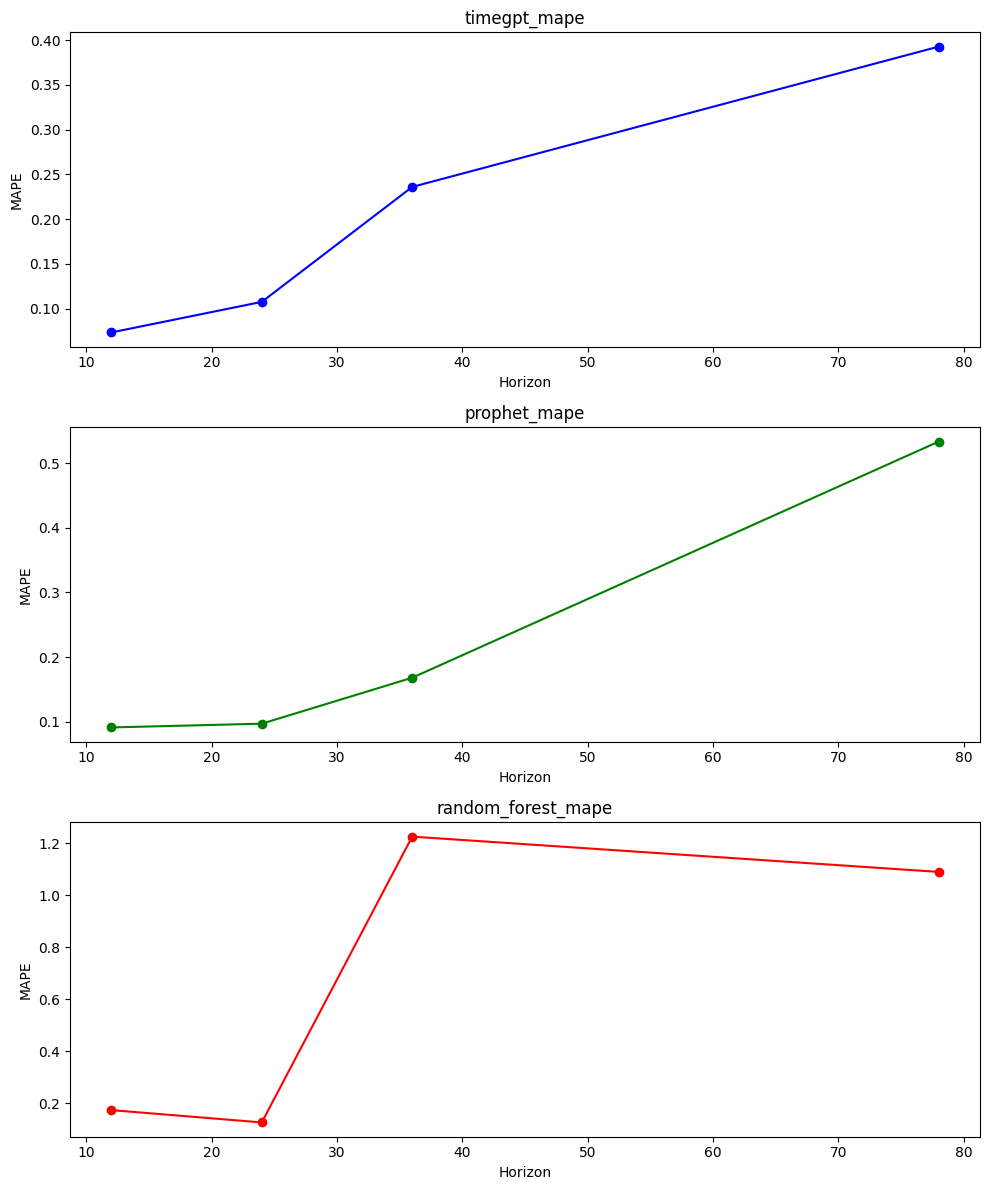

In [65]:
# 6.Plot history and forecast, do a visual inspection for 3 models prophet, time gpt and random forest

#Set 'horizon' as the index for better plotting
acc.set_index('horizon' , inplace = True)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12))

# Plot timegpt_mape
acc['timegpt_mape'].plot(ax=axes[0], marker='o', linestyle='-', color='b', label='Timegpt Mape')
axes[0].set_title('timegpt_mape')
axes[0].set_ylabel('MAPE')

# Plot prophet_mape
acc['prophet_mape'].plot(ax=axes[1], marker='o', linestyle='-', color='g', label='Prophet Mape')
axes[1].set_title('prophet_mape')
axes[1].set_ylabel('MAPE')

# Plot random_forest_mape
acc['random_forest_mape'].plot(ax=axes[2], marker='o', linestyle='-', color='r', label='Random Forest Mape')
axes[2].set_title('random_forest_mape')
axes[2].set_ylabel('MAPE')

# Set common x-axis label
for ax in axes:
    ax.set_xlabel('Horizon')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

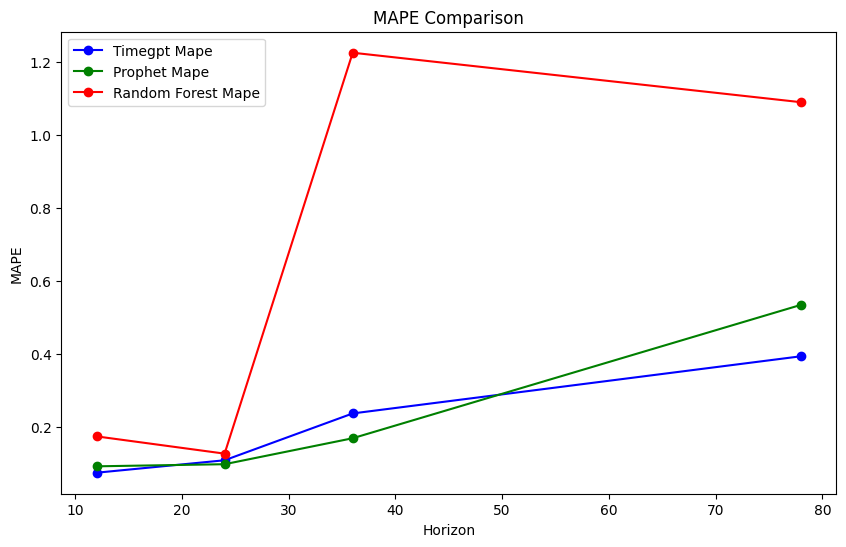

In [66]:

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot timegpt_mape
acc['timegpt_mape'].plot(ax=ax, marker='o', linestyle='-', color='b', label='Timegpt Mape')

# Plot prophet_mape
acc['prophet_mape'].plot(ax=ax, marker='o', linestyle='-', color='g', label='Prophet Mape')

# Plot random_forest_mape
acc['random_forest_mape'].plot(ax=ax, marker='o', linestyle='-', color='r', label='Random Forest Mape')

# Set labels and title
ax.set_xlabel('Horizon')
ax.set_ylabel('MAPE')
ax.set_title('MAPE Comparison')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [67]:
# Pending
# Double check not any step miss, make sure not missing anything
# Mape, generally comes between 0 - 1. The lowest the value the better (low error)

# 1.Calculate Weighted Mean Absolute Percentage Error for ML model
# 2.Compare ML and Time GPT Weighted  MAPE
# 4.Double check accuracy ML model
# 5.Plot history and forecast, do a visual inspection for 3 models prophet, time gpt and random forest
# 6.Add infomation about the runtime (for instance 3 minutes for 1 time gpt)



# 7.Extrapolate to a bigger sample of data
# 8.Visuals
# 9.Document
# Code into Git repo